In [8]:
import gymnasium as gym
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt


In [16]:
env = gym.make('CartPole-v1')
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Hyperparameters
alpha = 0.001  # Learning rate
gamma = 0.95  # Discount factor
num_episodes = 100000  # Number of episodes for training
epsilon = 0.01  # Exploration rate for epsilon-greedy policy
# Initialize weights for linear value function approximation
weights = np.random.rand(15) * 0.01
poly = PolynomialFeatures(degree=2)


In [17]:
scaler = StandardScaler()
state_samples = []
state = env.reset()[0]
while len(state_samples) < 10000:
    action = env.action_space.sample()
    next_state, _, done, _, _ = env.step(action)
    state_samples.append(state)
    if done:
        state = env.reset()[0]
    else:
        state = next_state

scaler.fit(state_samples)

StandardScaler()

Primera forma de fer-ho

In [18]:
# Feature function using polynomial features
def feature_function(state):
    return poly.fit_transform([state])[0]

def new_feature_function(state):
    cart_pos, cart_vel, pole_angle, pole_vel = state
    return np.array([1, cart_pos, cart_vel, pole_angle, pole_vel, 
                     cart_pos**2, cart_vel**2, pole_angle**2, pole_vel**2, 
                     cart_pos * cart_vel, cart_pos * pole_angle, cart_pos * pole_vel, 
                     cart_vel * pole_angle, cart_vel * pole_vel, pole_angle * pole_vel])

# Value function as a linear combination of features
def value_function(state, weights):
    features = new_feature_function(state)
    return np.dot(weights, features)

# Update weights using gradient Monte Carlo
def update_weights(weights, states, returns, alpha):
    for t in range(len(states)):
        features = feature_function(states[t])
        value_estimate = np.dot(weights, features)
        gradient = features
        weights += alpha * (returns[t] - value_estimate) * gradient
    return weights

# Generate a single episode using a given policy
def generate_episode(env, policy):
    episode = []
    state = env.reset()[0]
    done = False

    while not done:
        action = policy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, reward))
        state = next_state

    return episode

# Calculate returns for an episode
def calculate_returns(episode, gamma):
    returns = []
    G = 0
    for state, reward in reversed(episode):
        G = reward + gamma * G
        returns.insert(0, G)
    return returns

# Epsilon-greedy policy
def epsilon_greedy_policy(state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return 0 if value_function(state, weights) < 0 else 1  # Exploitation (assuming binary action space)

# Generate multiple episodes for evaluation
def generate_multiple_episodes(env, num_episodes, training=True):
    episodes = []
    for _ in range(num_episodes):
        episode = generate_episode(env, epsilon_greedy_policy)
        episodes.append(episode)
        # if training == False:
        #     print("end of episode")
    return episodes

# Calculate true returns for the initial state
def calculate_initial_state_returns(episodes, gamma):
    initial_state_returns = []
    for episode in episodes:
        _, rewards = zip(*episode)
        G = 0
        for reward in reversed(rewards):
            G = reward + gamma * G
        initial_state_returns.append(G)
    return initial_state_returns

# Calculate mean squared error
def mean_squared_error(estimated_value, true_values):
    true_values = np.array(true_values)
    mse = np.mean((true_values - estimated_value) ** 2)
    return mse




In [19]:
# Training loop
weight_history = []
for episode in range(num_episodes):
    episode_data = generate_episode(env, epsilon_greedy_policy)
    states, rewards = zip(*episode_data)
    returns = calculate_returns(episode_data, gamma)
    weights = update_weights(weights, states, returns, alpha)
    weight_history.append(weights.copy())
    if episode % 100 == 0:
        print(f"Episode {episode}, Weights: {weights}")

print("Training completed.")
print(f"Episode {episode}, Weights: {weights}")



Episode 0, Weights: [ 1.45957299e+01 -1.25439367e+00 -1.85411375e-01  1.96156166e-02
  9.65815392e-02  1.79923328e-01  2.32721786e-02 -3.18868020e-03
 -5.56496956e-02  2.84040094e-01  1.18875362e-02 -3.86424329e-01
 -2.35141514e-04 -2.01192143e-02  4.92510856e-01]
Episode 100, Weights: [ 1.18034906e+01 -1.26030629e+00 -1.31410605e+00  5.56179162e-02
  1.78543752e+00  1.80029781e-01  3.56257620e-02 -4.87489403e-03
 -7.49733215e-02 -2.31134523e-01  1.68470440e-02  3.76818814e-01
 -1.58211878e-03 -2.83049562e-02 -6.47234624e-01]
Episode 200, Weights: [ 1.04763734e+01 -1.24263372e+00 -1.59454280e+00  4.28911649e-02
  2.19589039e+00  1.82194846e-01  7.18867744e-02 -8.80524925e-03
 -1.30447993e-01 -5.36972349e-02 -2.30406520e-02  9.44326567e-02
  1.98370570e-03  3.26689813e-02 -2.02600299e-01]
Episode 300, Weights: [ 9.64721598e+00 -1.23734810e+00 -1.75330055e+00  4.92390935e-02
  2.44683875e+00  1.83013300e-01  8.77641844e-02 -1.02989181e-02
 -1.54439634e-01  2.40430247e-02 -3.48227276e-02 

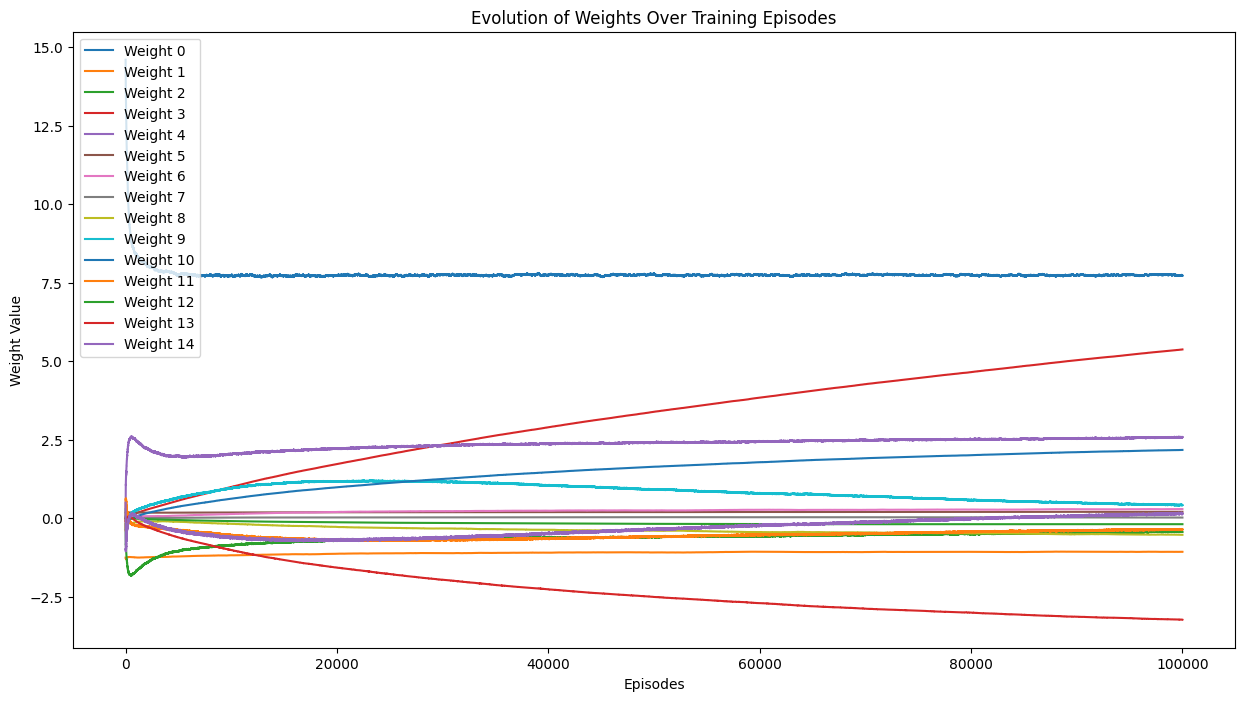

In [20]:
weight_history = np.array(weight_history)
plt.figure(figsize=(15, 8))
for i in range(weight_history.shape[1]):
    plt.plot(weight_history[:, i], label=f'Weight {i}')
plt.xlabel('Episodes')
plt.ylabel('Weight Value')
plt.title('Evolution of Weights Over Training Episodes')
plt.legend()
plt.show()

In [21]:
weights

array([ 7.7235768 , -1.06975718, -0.43258914,  5.37247339,  2.58134872,
        0.20368688,  0.29070239,  0.02069357, -0.52904021,  0.4176684 ,
        2.17324331, -0.3578465 , -0.19057756, -3.23090333,  0.14296237])

In [22]:
env = gym.make('CartPole-v1', render_mode="human")
# Estimate the value of the initial state
state = env.reset()[0]
estimated_value = value_function(state, weights)
print(estimated_value)
print(state)


7.387234429767673
[ 0.02638722 -0.0278719  -0.03474671 -0.04897833]


In [24]:

state = scaler.fit_transform([state])[0]
state

array([0., 0., 0., 0.])

In [26]:
weights[0] = 0.019811894
# weights[0] = 7.86185392
estimated_value = value_function(state, weights)
print(estimated_value)

-0.7856138958650742


In [27]:
episode = []


while True:
    total_reward = 0
    state = env.reset()[0]
    done = False
    while not done:
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, reward))
        state = next_state
        total_reward += reward
        if total_reward >= 200:
            done = True
    print(total_reward)

121.0
102.0
200.0
165.0


KeyboardInterrupt: 

In [12]:
env.close()

In [362]:
action = epsilon_greedy_policy(state, epsilon)
next_state, reward, done, _, _ = env.step(action)
episode.append((state, reward))
state = next_state
print("action:", action)
print("state:", state)

action: 1
state: [ 4.5038314  9.15921   -5.046462  -2.2106833]


In [23]:
print(next_state, reward, done)

[ 0.00944229  1.1322453  -0.12292526 -1.8395344 ] 1.0 False


In [270]:
episodes = []
for _ in range(num_episodes):
    episode = generate_episode(env, epsilon_greedy_policy)
    episodes.append(episode)
    # if training == False:
    #     print("end of episode")

KeyboardInterrupt: 

In [60]:
# Define feature extraction function with normalization and polynomial features
def extract_features(state):
    normalized_state = scaler.transform([state])[0]
    return poly.fit_transform([normalized_state])[0]  # Polynomial features
# Value function approximation
def value_function(state, weights):
    features = extract_features(state)
    return np.dot(features, weights)
# Epsilon-greedy policy
def epsilon_greedy_policy(state, weights, epsilon=0.1):
    if np.random.rand() < epsilon:
        # print("random")
        return env.action_space.sample()  # Exploration
        # return 0
    else:
        # print("chosen by value_function")
        return 0 if value_function(state, weights) < 0 else 1  # Exploitation (assuming binary action space)
# Generate an episode
def generate_episode(env, policy, weights, epsilon=0.1):
    episode = []
    state = env.reset()[0]
    done = False
    while not done:
        action = policy(state, weights, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        # print(action)
    return episode
# Update weights using Monte Carlo method
def update_weights(episode, weights, alpha=0.01, gamma=0.99, lambda_reg=0.01):
    G = 0
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = gamma * G + reward
        features = extract_features(state)
        delta = G - np.dot(features, weights)  # Prediction error
        weights += alpha * delta * features  # Gradient update
        weights -= alpha * lambda_reg * weights  # L2 regularization
    return weights

In [64]:
# Training the agent
num_episodes = 1000
epsilon = 0.1
alpha = 0.01
gamma = 0.99
lambda_reg = 0.01  # Regularization strength
weights = np.random.rand(15) * 0.01  # Smaller initial weights
previous_weights = weights.copy()

# Track weight evolution
weight_history = []

# Set learning rate decay
alpha_decay = alpha / num_episodes

# Epsilon decay
epsilon_decay = epsilon / num_episodes

convergence_threshold = 1e-6
consecutive_converged_episodes = 10

In [65]:
env = gym.make('CartPole-v1')

In [68]:


# for episode in range(num_episodes):
for episode in range(100000):
    ep = generate_episode(env, epsilon_greedy_policy, weights, 0.05)
    weights = update_weights(ep, weights, alpha, gamma, lambda_reg)
    weight_history.append(weights.copy())

    # Check for convergence
    max_weight_change = np.max(np.abs(weights - previous_weights))
    previous_weights = weights.copy()
    
    if max_weight_change < convergence_threshold:
        converged_episode_count += 1
    else:
        converged_episode_count = 0
    
    if converged_episode_count >= consecutive_converged_episodes:
        print(f"Weights converged after {episode} episodes.")
        break
    
    # Decay learning rate and epsilon
    alpha -= alpha_decay
    epsilon -= epsilon_decay
    if episode % 100 == 0:
        initial_state = env.reset()[0]
        estimated_value = value_function(initial_state, weights)
        print(f"Episode {episode}, Estimated Value of Initial State: {estimated_value}")
        print(f"Weights: {weights}")
        print(f"Initial State: {initial_state}")

# print(weights)
# if episode % 100 == 0:
#     initial_state = env.reset()[0]
#     print(f"Episode {episode}, Estimated Value of Initial State: {value_function(initial_state, weights)}")
#     print(weights)


Episode 0, Estimated Value of Initial State: 0.8610196587323196
Weights: [ 0.88805533  0.06140039  0.47649666  0.09658979 -0.44227026  0.0428974
 -0.07228402  0.03417939  0.10241864  0.37411998  0.17494793 -0.32642475
 -0.08036803 -0.18703259  0.3023487 ]
Initial State: [-0.02711449 -0.01150963  0.00600574  0.01087235]
Episode 100, Estimated Value of Initial State: 7.051273569974655
Weights: [ 6.87107476  0.33784681  0.645838    0.80474536 -0.53839333  0.67389234
  0.05963291 -0.26276096 -0.07147563 -0.30491865  0.22963817  0.39714816
  1.00709083 -0.1747333  -0.43997276]
Initial State: [ 0.03804173  0.04479313 -0.0137719   0.01466445]
Episode 200, Estimated Value of Initial State: 8.23508533268863
Weights: [ 7.5992847   0.36028695 -0.02507963  1.32545779  0.22623927  0.69905931
  0.07134879 -0.04966335 -0.03877341 -0.1917021   0.27047003  0.32329512
  0.88919068 -0.25853632 -0.41136659]
Initial State: [-0.01375932 -0.0321798   0.03770425 -0.01479559]
Episode 300, Estimated Value of In

KeyboardInterrupt: 

: 

In [597]:
episode = []
state = env.reset()[0]
done = False
while not done:
    action = policy(state, weights, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    episode.append((state, action, reward))
    state = next_state

array([ 2.1873147 , -0.10166084,  1.06906991,  0.40120832, -0.87972339,
        0.07801239, -0.19279982,  0.19343528,  0.23773787,  0.43983472,
        0.60419481, -0.26669262, -0.01764664, -0.57723105,  0.14075253])

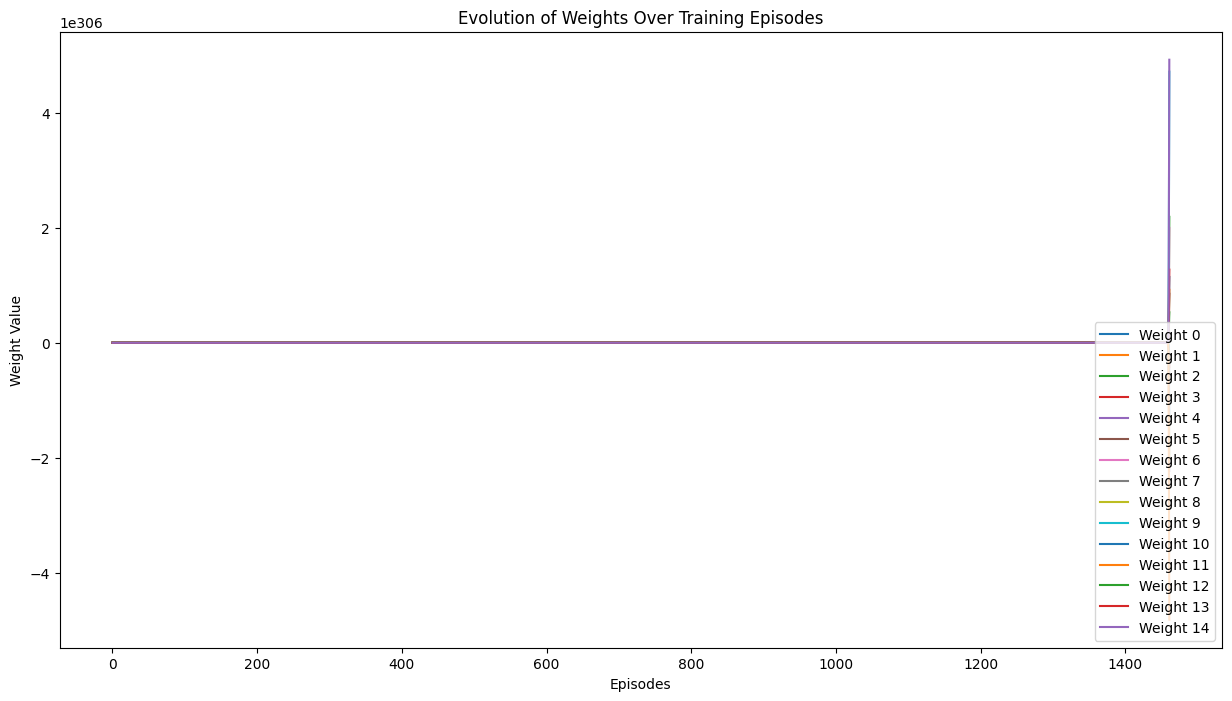

In [53]:
weight_history_1 = np.array(weight_history)
plt.figure(figsize=(15, 8))
for i in range(weight_history_1.shape[1]):
    plt.plot(weight_history_1[:, i], label=f'Weight {i}')
plt.xlabel('Episodes')
plt.ylabel('Weight Value')
plt.title('Evolution of Weights Over Training Episodes')
plt.legend()
plt.show()

In [54]:
env = gym.make('CartPole-v1', render_mode = "human")
# weights[0] = 0.019811894


In [55]:
state = env.reset()[0]
done = False
while not done:
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    episode.append((state, action, reward))
    state = next_state

# while not done:
#     action = epsilon_greedy_policy(state, epsilon=0.0)  # Exploitation only
#     next_state, reward, done, _, _ = env.step(action)
#     env.render()
#     state = next_state

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [28]:
env.close()